In [1]:
import pandas as pd

df = pd.read_excel("RSE_copy.xlsx")

In [2]:
df.columns

Index(['DA_SHIPMENT_NUMBER', 'DA_DOCUMENT_NUMBER', 'Initial_SI_received_time',
       'Initial_Booking_request_received_time', 'DA_START_GEO_RE',
       'DA_START_GEO_SR', 'DA_START_GEO_AR', 'DA_START_GEO_SA',
       'DA_START_STD_LOC', 'DA_LAST_POD', 'DA_END_STD_LOC', 'DA_END_GEO_RE',
       'DA_END_GEO_SR', 'DA_END_GEO_AR', 'DA_END_GEO_SA', 'DA_CU', 'DA_IS',
       'Doc_Cut_off_date', ' holidays & weekends'],
      dtype='object')

In [3]:
df.set_index('Initial_SI_received_time', inplace=True)
df['day_of_week'] = df.index.dayofweek
df['hour'] = df.index.hour
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

In [4]:
df['si_received_count'] = 1
hourly_si = df['si_received_count'].resample('h').sum()
hourly_si_filtered = hourly_si['2023-01-01':'2025-08-31']

In [5]:
calendar_features = df[['day_of_week', 'is_weekend']].copy()
calendar_features_hourly = calendar_features.resample('h').max().fillna(0)

In [6]:
hourly_si_filtered = hourly_si_filtered.to_frame(name='SI_count')
calendar_features_filtered = calendar_features_hourly.reindex(hourly_si_filtered.index, fill_value=0)
hourly_si_filtered = hourly_si_filtered.join(calendar_features_filtered)

In [7]:
hourly_si_filtered['day_of_week'] = hourly_si_filtered['day_of_week'].astype(int)
hourly_si_filtered['is_weekend'] = hourly_si_filtered['is_weekend'].astype(int)

In [8]:
hourly_si_filtered.columns

Index(['SI_count', 'day_of_week', 'is_weekend'], dtype='object')

In [23]:
from sklearn.preprocessing import MinMaxScaler

features = ['SI_count', 'day_of_week', 'is_weekend']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(hourly_si_filtered[features])

In [24]:
import numpy as np

seq_len = 48
forecast_horizon = 60

X, y = [], []

for i in range(seq_len, len(scaled_data) - forecast_horizon):
    X.append(scaled_data[i-seq_len:i])
    y.append(scaled_data[i:i+forecast_horizon, 0])

X = np.array(X)
y = np.array(y)

print(f"Input shape: {X.shape}")  
print(f"Target shape: {y.shape}")

Input shape: (23268, 48, 3)
Target shape: (23268, 60)


In [25]:
split_ratio = 0.8

split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [40]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


lr_schedule = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model = Sequential([
            Input(shape=(X_train.shape[1], X_train.shape[2])),
            LSTM(128, return_sequences=True),
            Dropout(0.3),
            LSTM(64, kernel_regularizer=l2(0.001)),
            Dropout(0.3),
            Dense(forecast_horizon)
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

history = model.fit(
    X_train, y_train,
    epochs = 100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop,lr_schedule],
    verbose=1
)

Epoch 1/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - loss: 0.0981 - val_loss: 0.0612 - learning_rate: 1.0000e-04
Epoch 2/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 36s 63ms/step - loss: 0.0229 - val_loss: 0.0224 - learning_rate: 1.0000e-04
Epoch 3/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 34s 59ms/step - loss: 0.0064 - val_loss: 0.0164 - learning_rate: 1.0000e-04
Epoch 4/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 34s 59ms/step - loss: 0.0038 - val_loss: 0.0154 - learning_rate: 1.0000e-04
Epoch 5/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 45s 65ms/step - loss: 0.0034 - val_loss: 0.0143 - learning_rate: 1.0000e-04
Epoch 6/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 37s 64ms/step - loss: 0.0031 - val_loss: 0.0135 - learning_rate: 1.0000e-04
Epoch 7/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 36s 63ms/step - loss: 0.0029 - val_loss: 0.0129 - learning_rate: 1.0000e-04
Epoch 8/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 39s 67ms/step - loss: 0.0028 - val_loss: 0.0137 - learning_rate: 1.0000e-04
Epoch 9/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 39s 66ms/step - loss: 0

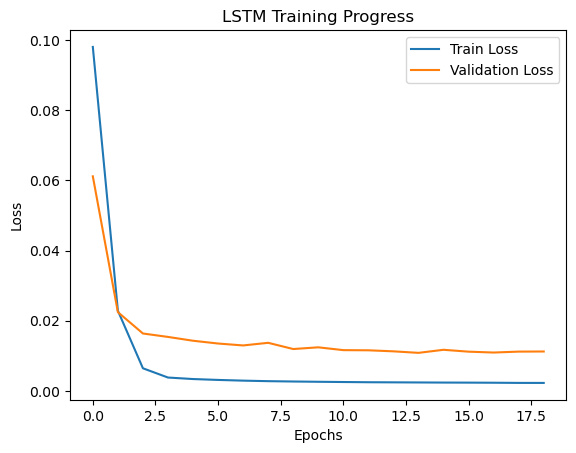

In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training Progress')
plt.show()

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
MAE: 0.06282729207856626
RMSE: 0.10381671657253827
R²: 0.6575239165875579


In [43]:
model_1 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64),
    Dropout(0.2),
    Dense(forecast_horizon)
])


lr_schedule = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_1.compile(optimizer="adam", loss='mse')

history = model_1.fit(
    X_train, y_train,
    epochs = 100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop,lr_schedule],
    verbose=1
)

Epoch 1/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 0.0043 - val_loss: 0.0147 - learning_rate: 0.0010
Epoch 2/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 0.0029 - val_loss: 0.0113 - learning_rate: 0.0010
Epoch 3/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.0025 - val_loss: 0.0105 - learning_rate: 0.0010
Epoch 4/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 0.0022 - val_loss: 0.0097 - learning_rate: 0.0010
Epoch 5/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - loss: 0.0021 - val_loss: 0.0098 - learning_rate: 0.0010
Epoch 6/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.0021 - val_loss: 0.0094 - learning_rate: 0.0010
Epoch 7/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - loss: 0.0020 - val_loss: 0.0093 - learning_rate: 0.0010
Epoch 8/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 0.0019 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 9/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0019 - val_loss: 0.0086 - learn

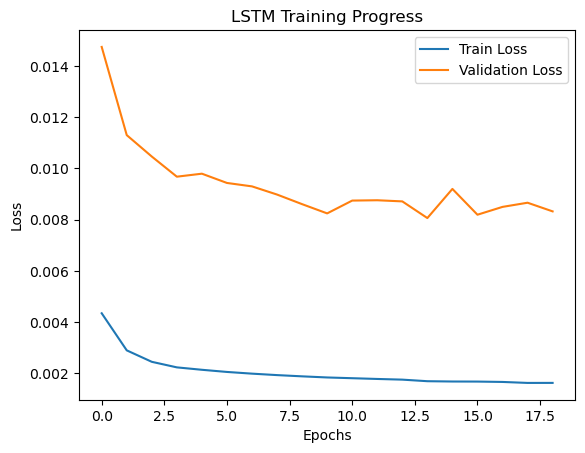

In [44]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training Progress')
plt.show()

In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model_1.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
MAE: 0.051510089427669895
RMSE: 0.08977719543060247
R²: 0.7438910119993805


In [57]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


lr_schedule = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_2 = Sequential([
            Input(shape=(X_train.shape[1], X_train.shape[2])),
            LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)),
            Dropout(0.3),
            LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
            Dropout(0.3),
            LSTM(32, return_sequences=False, kernel_regularizer=l2(0.001)),
            Dropout(0.3),
            Dense(forecast_horizon)
])

model_2.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

history_2 = model.fit(
    X_train, y_train,
    epochs = 100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop,lr_schedule],
    verbose=1
)

Epoch 1/100
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 64s 55ms/step - loss: 0.0022 - val_loss: 0.0111 - learning_rate: 6.2500e-06
Epoch 2/100
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 59s 51ms/step - loss: 0.0022 - val_loss: 0.0110 - learning_rate: 6.2500e-06
Epoch 3/100
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 59s 51ms/step - loss: 0.0022 - val_loss: 0.0111 - learning_rate: 6.2500e-06
Epoch 4/100
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 64s 55ms/step - loss: 0.0022 - val_loss: 0.0113 - learning_rate: 6.2500e-06
Epoch 5/100
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 65s 56ms/step - loss: 0.0022 - val_loss: 0.0112 - learning_rate: 3.1250e-06
Epoch 6/100
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 60s 52ms/step - loss: 0.0022 - val_loss: 0.0112 - learning_rate: 3.1250e-06
Epoch 7/100
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 61s 52ms/step - loss: 0.0022 - val_loss: 0.0111 - learning_rate: 3.1250e-06
Epoch 8/100
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 64s 55ms/step - loss: 0.0022 - val_loss: 0.0112 - learning_rate: 1.5625e-06
Epoch 9/100
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 65s 5

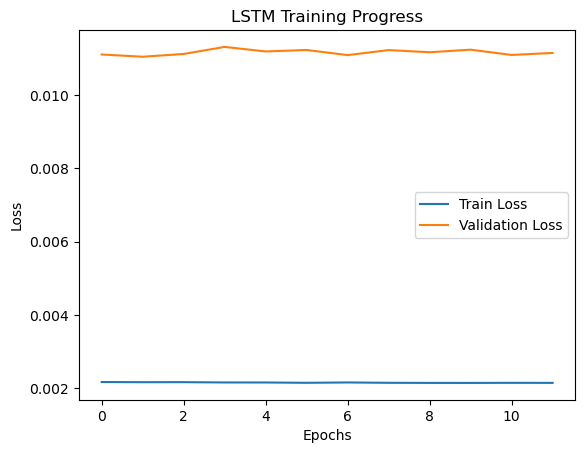

In [58]:
import matplotlib.pyplot as plt

plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training Progress')
plt.show()

In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model_2.predict(X_test)

y_pred = y_pred.squeeze()
y_test = y_test.squeeze()


print("MAE:", mean_absolute_error(y_test.flatten(), y_pred.flatten()))
print("RMSE:", np.sqrt(mean_squared_error(y_test.flatten(), y_pred.flatten())))
print("R²:", r2_score(y_test.flatten(), y_pred.flatten()))

146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step
MAE: 0.11968498755947451
RMSE: 0.21153400774571215
R²: -0.4218029349378256


## for 60 days

In [14]:
import numpy as np

seq_len = 720              
forecast_horizon = 1440    

X, y = [], []

for i in range(seq_len, len(scaled_data) - forecast_horizon):

    X.append(scaled_data[i-seq_len:i])
    y.append(scaled_data[i:i+forecast_horizon, 0])

X = np.array(X)
y = np.array(y)

print(f"Input shape: {X.shape}")   
print(f"Target shape: {y.shape}")  

Input shape: (21216, 720, 3)
Target shape: (21216, 1440)


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(forecast_horizon)   
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')


lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, lr_schedule],
    verbose=1
)

Epoch 1/100
531/531 ━━━━━━━━━━━━━━━━━━━━ 244s 455ms/step - loss: 0.0083 - val_loss: 0.0204 - learning_rate: 1.0000e-04
Epoch 2/100
531/531 ━━━━━━━━━━━━━━━━━━━━ 298s 561ms/step - loss: 0.0046 - val_loss: 0.0197 - learning_rate: 1.0000e-04
Epoch 3/100
531/531 ━━━━━━━━━━━━━━━━━━━━ 292s 551ms/step - loss: 0.0043 - val_loss: 0.0183 - learning_rate: 1.0000e-04
Epoch 4/100
531/531 ━━━━━━━━━━━━━━━━━━━━ 286s 539ms/step - loss: 0.0039 - val_loss: 0.0168 - learning_rate: 1.0000e-04
Epoch 5/100
531/531 ━━━━━━━━━━━━━━━━━━━━ 301s 567ms/step - loss: 0.0035 - val_loss: 0.0160 - learning_rate: 1.0000e-04
Epoch 6/100
531/531 ━━━━━━━━━━━━━━━━━━━━ 299s 562ms/step - loss: 0.0032 - val_loss: 0.0153 - learning_rate: 1.0000e-04
Epoch 7/100
531/531 ━━━━━━━━━━━━━━━━━━━━ 297s 559ms/step - loss: 0.0030 - val_loss: 0.0150 - learning_rate: 1.0000e-04
Epoch 8/100
531/531 ━━━━━━━━━━━━━━━━━━━━ 291s 549ms/step - loss: 0.0029 - val_loss: 0.0148 - learning_rate: 1.0000e-04
Epoch 9/100
531/531 ━━━━━━━━━━━━━━━━━━━━ 294s 55

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test)

y_pred = y_pred.squeeze()
y_test = y_test.squeeze()


print("MAE:", mean_absolute_error(y_test.flatten(), y_pred.flatten()))
print("RMSE:", np.sqrt(mean_squared_error(y_test.flatten(), y_pred.flatten())))
print("R²:", r2_score(y_test.flatten(), y_pred.flatten()))

133/133 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step
MAE: 0.06364105385666752
RMSE: 0.11275773890925596
R²: 0.5822773422611305


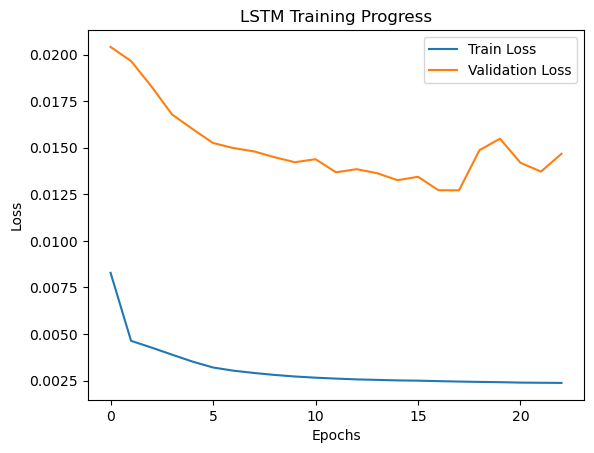

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training Progress')
plt.show()

In [19]:
model.save("LSTM_model.h5")

In [21]:
import pandas as pd
from datetime import timedelta

# Take last sequence from dataset
last_sequence = scaled_data[-seq_len:]
last_sequence = last_sequence.reshape(1, seq_len, scaled_data.shape[1])

# Predict 1440 hours directly
future_pred = model.predict(last_sequence, verbose=0)[0]   # shape (1440,)

# Reshape for inverse scaling
future_pred_full = future_pred.reshape(-1, 1)

# Pad with zeros for other features if >1 input feature
future_pred_padded = np.concatenate([
    future_pred_full,
    np.zeros((forecast_horizon, scaled_data.shape[1] - 1))
], axis=1)

# Inverse transform back to original scale
future_pred_inv = scaler.inverse_transform(future_pred_padded)[:, 0]

# Build timestamps
last_timestamp = hourly_si_filtered.index[-1]
future_timestamps = [last_timestamp + timedelta(hours=i+1) for i in range(forecast_horizon)]

# Forecast DataFrame
df_forecast_lstm = pd.DataFrame({
    'timestamp': future_timestamps,
    'predicted_si_count': future_pred_inv
})

print(df_forecast_lstm)   # preview first 48 hours

               timestamp  predicted_si_count
0    2025-09-01 00:00:00            5.741775
1    2025-09-01 01:00:00            6.086128
2    2025-09-01 02:00:00            8.326244
3    2025-09-01 03:00:00           12.485655
4    2025-09-01 04:00:00           19.055712
...                  ...                 ...
1435 2025-10-30 19:00:00            0.540601
1436 2025-10-30 20:00:00           -1.736698
1437 2025-10-30 21:00:00           -3.439837
1438 2025-10-30 22:00:00           -4.067432
1439 2025-10-30 23:00:00           -3.731848

[1440 rows x 2 columns]


In [23]:
df_forecast_lstm.to_csv('multioutput_result.csv')

In [1]:
import pandas as pd

df = pd.read_excel(r"C:\Users\ISMAIMZ\OneDrive - Hapag-Lloyd AG\Documents\DA\Booking time prediction\South_europe\sep_oct_final.xlsx")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     1440 non-null   datetime64[ns]
 1   actual_count  1440 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 22.6 KB


In [3]:
df = df.rename(columns={'hour': 'timestamp',
                        'count': 'actual_count'})

In [4]:
df_1 = pd.read_excel(r"C:\Users\ISMAIMZ\OneDrive - Hapag-Lloyd AG\Documents\DA\Booking time prediction\South_europe\multiop_result.xlsx")

In [8]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        1440 non-null   datetime64[ns]
 1   predicted_count  1440 non-null   int32         
dtypes: datetime64[ns](1), int32(1)
memory usage: 17.0 KB


In [6]:
df_1 = df_1.rename(columns={'predicted_si_count': 'predicted_count'})

In [7]:
df_1['predicted_count'] = df_1['predicted_count'].astype(int) 

In [35]:
df_merged = pd.merge(df, df_1, on='timestamp', how='inner')

def classify_prediction(row):
    actual = row['actual_count']
    predicted = row['predicted_count']

    if actual == predicted:
        return 'Exact Match'
    elif abs(actual - predicted) <= 3:
        return '+/- 3 range'
    elif abs(actual - predicted) <= 5:
        return '+/- 5 range'
    else:
        return 'Very low prediction'

def calculate_accuracy(row):
    actual = row['actual_count']
    predicted = row['predicted_count']

    if actual == 0:
        return 0
    else:
        return round((1 - abs(actual - predicted) / actual) * 100)

def categorize_accuracy(row):
    if row['match_status'] == 'No SI Received':
        return 'Mismatch'
    elif row['accuracy_percent'] is None:
        return 'Mismatch'
    elif row['accuracy_percent'] >= 90:
        return 'High'
    elif row['accuracy_percent'] >= 60:
        return 'Medium'
    else:
        return 'Low'

df_merged['match_status'] = df_merged.apply(classify_prediction, axis=1)
df_merged['accuracy_percent'] = df_merged.apply(calculate_accuracy, axis=1)
df_merged['accuracy_category'] = df_merged.apply(categorize_accuracy, axis=1)

print(df_merged[['timestamp', 'actual_count', 'predicted_count', 'match_status', 'accuracy_percent', 'accuracy_category']])

               timestamp  actual_count  predicted_count         match_status  \
0    2025-09-01 00:00:00             0                5          +/- 5 range   
1    2025-09-01 01:00:00             0                6  Very low prediction   
2    2025-09-01 13:00:00             4               48  Very low prediction   
3    2025-09-01 14:00:00             2               40  Very low prediction   
4    2025-09-01 15:00:00             0               31  Very low prediction   
...                  ...           ...              ...                  ...   
1424 2025-10-30 19:00:00             3                0          +/- 3 range   
1425 2025-10-30 20:00:00             4               -1          +/- 5 range   
1426 2025-10-30 21:00:00             3               -3  Very low prediction   
1427 2025-10-30 22:00:00             4               -4  Very low prediction   
1428 2025-10-30 23:00:00             0               -3          +/- 3 range   

      accuracy_percent accuracy_categor

In [36]:
df_merged.to_csv('multiop_res_final.csv')

In [13]:
df_merged = pd.merge(df, df_1, on='timestamp', how='inner')

def classify_prediction(row):
    actual = row['actual_count']
    predicted = row['predicted_count']

    if actual == predicted:
        return 'Exact Match'
    elif actual == 0:
        return 'No SI Received'
    elif abs(actual - predicted) <= 3:
        return '+/- 3 range'
    elif abs(actual - predicted) <= 5:
        return '+/- 5 range'
    elif abs(actual - predicted) <= 10:
        return '+/- 10 Range'
    else:
        return 'More than +/- 10 Range'


df_merged['match_status'] = df_merged.apply(classify_prediction, axis=1)

print(df_merged[['timestamp', 'actual_count', 'predicted_count', 'match_status']])

               timestamp  actual_count  predicted_count    match_status
0    2025-09-01 00:00:00             0                5  No SI Received
1    2025-09-01 01:00:00             0                6  No SI Received
2    2025-09-01 02:00:00             0                8  No SI Received
3    2025-09-01 03:00:00             0               12  No SI Received
4    2025-09-01 04:00:00             0               19  No SI Received
...                  ...           ...              ...             ...
1435 2025-10-30 19:00:00             3                0     +/- 3 range
1436 2025-10-30 20:00:00             4               -1     +/- 5 range
1437 2025-10-30 21:00:00             3               -3    +/- 10 Range
1438 2025-10-30 22:00:00             4               -4    +/- 10 Range
1439 2025-10-30 23:00:00             0               -3  No SI Received

[1440 rows x 4 columns]


In [14]:
df_merged.to_csv('test.csv')

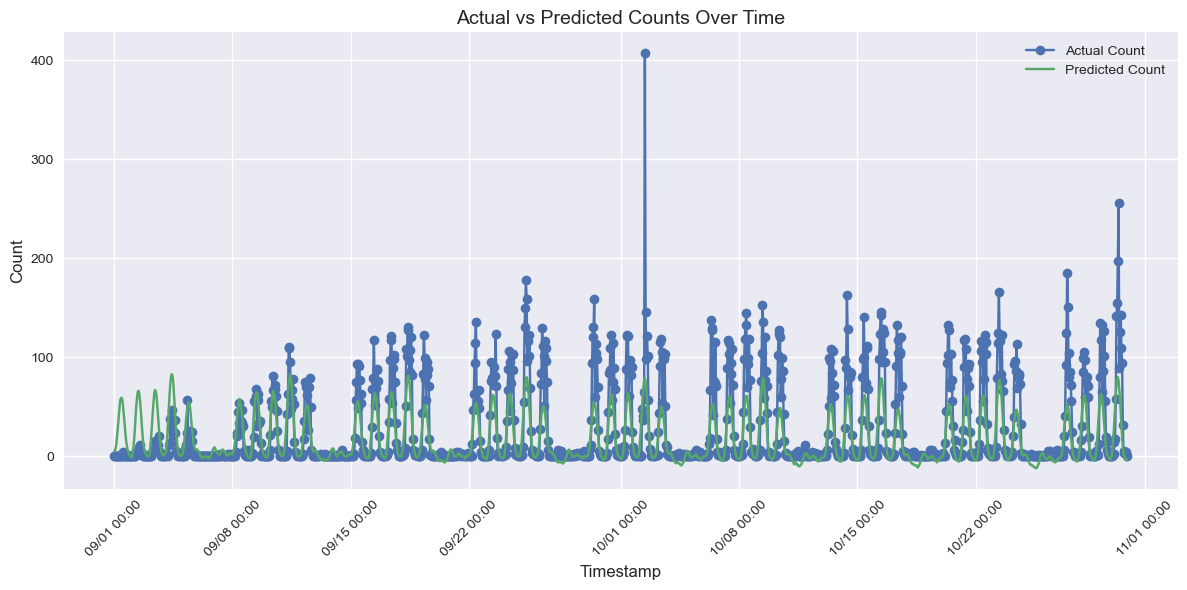

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime


fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_merged["timestamp"], df_merged["actual_count"], label="Actual Count", marker='o')
ax.plot(df_merged["timestamp"], df_merged["predicted_count"], label="Predicted Count", marker='x')

# Formatting
ax.set_title("Actual vs Predicted Counts Over Time", fontsize=14)
ax.set_xlabel("Timestamp", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
hourly_si_filtered

,SI_count,day_of_week,is_weekend
Initial_SI_received_time,,,
2023-01-01 00:00:00,0,0,0
2023-01-01 01:00:00,0,0,0
2023-01-01 02:00:00,0,0,0
2023-01-01 03:00:00,0,0,0
2023-01-01 04:00:00,0,0,0
...,...,...,...
2025-08-31 19:00:00,0,0,0
2025-08-31 20:00:00,0,0,0
2025-08-31 21:00:00,2,6,1


In [30]:
df = hourly_si_filtered.copy()

df['dow_sin'] = np.sin(2*np.pi*df['day_of_week']/7)
df['dow_cos'] = np.cos(2*np.pi*df['day_of_week']/7)

In [34]:
from sklearn.preprocessing import MinMaxScaler

features = ['SI_count', 'dow_sin', 'dow_cos', 'is_weekend']

split_ratio = 0.8
split_index = int(len(df) * split_ratio)

train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_df[features])
scaled_test = scaler.transform(test_df[features])

In [35]:
import numpy as np

seq_len = 48
X_train, y_train = [], []
for i in range(seq_len, len(scaled_train)):
    X_train.append(scaled_train[i-seq_len:i])
    y_train.append(scaled_train[i,0])  

X_test, y_test = [], []
for i in range(seq_len, len(scaled_test)):
    X_test.append(scaled_test[i-seq_len:i])
    y_test.append(scaled_test[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

val_ratio = 0.1
val_index = int(len(X_train) * (1 - val_ratio))

X_val, y_val = X_train[val_index:], y_train[val_index:]
X_train, y_train = X_train[:val_index], y_train[:val_index]

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Validation shape: {X_val.shape}, {y_val.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")

Train shape: (16786, 48, 4), (16786,)
Validation shape: (1866, 48, 4), (1866,)
Test shape: (4628, 48, 4), (4628,)


In [36]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from sklearn.utils.class_weight import compute_class_weight

y_train_bin = (y_train > 0).astype(int)
y_test_bin = (y_test > 0).astype(int)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_bin),
    y=y_train_bin
)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

clf_model = Sequential([
            Input(shape=(X_train.shape[1], X_train.shape[2])),
            LSTM(64),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
])

clf_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

clf_lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
clf_early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

clf_model.fit(
    X_train, (y_train > 0).astype(int),  
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test_bin),
    callbacks=[clf_early_stop, clf_lr_schedule],
    class_weight=class_weight_dict,
    verbose=1
)


X_train_reg = X_train[y_train > 0]
y_train_reg = np.log1p(y_train[y_train > 0])   
X_test_reg = X_test[y_test > 0]
y_test_reg = np.log1p(y_test[y_test > 0])

reg_model = Sequential([
    Input(shape=(X_train_reg.shape[1], X_train_reg.shape[2])),
    LSTM(128),
    Dropout(0.2),
    Dense(1)
])

reg_model.compile(optimizer=Adam(learning_rate=1e-4), loss=Huber())

reg_lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
reg_early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = reg_model.fit(
    X_train_reg, y_train_reg,
    epochs=100,
    batch_size=16,
    validation_data=(X_test_reg, y_test_reg),
    callbacks=[reg_early_stop, reg_lr_schedule],
    verbose=1
)

Epoch 1/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.6762 - loss: 0.6115 - val_accuracy: 0.7645 - val_loss: 0.4818 - learning_rate: 1.0000e-04
Epoch 2/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.7908 - loss: 0.4320 - val_accuracy: 0.7707 - val_loss: 0.4652 - learning_rate: 1.0000e-04
Epoch 3/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.7988 - loss: 0.4121 - val_accuracy: 0.7777 - val_loss: 0.4310 - learning_rate: 1.0000e-04
Epoch 4/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.8044 - loss: 0.4019 - val_accuracy: 0.7919 - val_loss: 0.4110 - learning_rate: 1.0000e-04
Epoch 5/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.8051 - loss: 0.3963 - val_accuracy: 0.7787 - val_loss: 0.4404 - learning_rate: 1.0000e-04
Epoch 6/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.8060 - loss: 0.3948 - val_accuracy: 0.7850 - val_loss: 0.4140 - learning_rate: 1.0000e-04
Epoch 7/50
1050/1050 ━━━━━━━━━━━━━━━━━━━

In [18]:
reg_model.save("LSTM_Multi_model.h5")

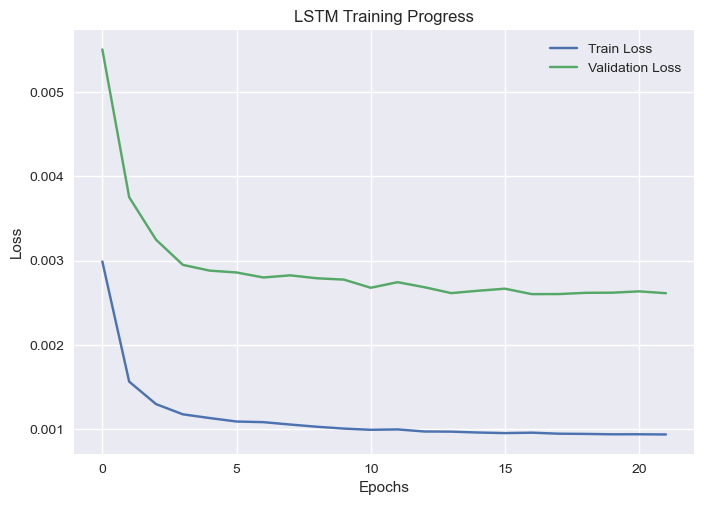

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training Progress')
plt.show()

In [43]:
import numpy as np
import pandas as pd
from datetime import timedelta

seq_len = 48
forecast_horizon = 1440


last_sequence = scaled_data[-seq_len:]
last_sequence = last_sequence.reshape(1, seq_len, scaled_data.shape[1])

future_pred = []
current_input = last_sequence.copy()

for _ in range(forecast_horizon):
    next_pred = reg_model.predict(current_input)
    future_pred.append(next_pred[0, 0])

    next_pred_reshaped = next_pred.reshape(1, 1, 1)

    if scaled_data.shape[1] > 1:
        pad = np.zeros((1, 1, scaled_data.shape[1] - 1))
        next_step = np.concatenate((next_pred_reshaped, pad), axis=2)
    else:
        next_step = next_pred_reshaped

    current_input = np.concatenate((current_input[:, 1:, :], next_step), axis=1)

future_pred_full = np.array(future_pred).reshape(-1, 1)

future_pred_padded = np.concatenate([
    future_pred_full,           
    np.zeros((forecast_horizon, scaled_data.shape[1] - 1))], axis=1)

future_pred_inv = scaler.inverse_transform(future_pred_padded)[:, 0]

total_si_next_48 = future_pred_inv.sum()
print(f"Predicted total SI count for next 48 hours: {total_si_next_48:.2f}")

last_timestamp = hourly_si_filtered.index[-1]
future_timestamps = [last_timestamp + timedelta(hours=i+1) for i in range(forecast_horizon)]

df_forecast_lstm = pd.DataFrame({
    'timestamp': future_timestamps,
    'predicted_si_count': future_pred_inv
})

print(df_forecast_lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

In [49]:
df_forecast_lstm.to_csv('multi_model_LSTM.csv')

In [56]:
import pandas as pd

df = pd.read_excel(r"C:\Users\ISMAIMZ\OneDrive - Hapag-Lloyd AG\Documents\DA\Booking time prediction\South_europe\sep_oct_final.xlsx")

df = df.rename(columns={'hour': 'timestamp',
                        'count': 'actual_count'})

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     1440 non-null   datetime64[ns]
 1   actual_count  1440 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 22.6 KB


In [69]:
df_1 = pd.read_csv(r"C:\Users\ISMAIMZ\OneDrive - Hapag-Lloyd AG\Documents\DA\Booking time prediction\South_europe\test.csv")

df_1 = df_1.rename(columns={'predicted_si_count': 'predicted_count'})
df_1['predicted_count'] = df_1['predicted_count'].astype(int) 

In [70]:
df_1['timestamp'] = pd.to_datetime(df_1['timestamp'])

In [71]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        1440 non-null   datetime64[ns]
 1   predicted_count  1440 non-null   int32         
dtypes: datetime64[ns](1), int32(1)
memory usage: 17.0 KB


In [72]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df_merged = pd.merge(df, df_1, on='timestamp', how='inner')

def classify_prediction(row):
    actual = row['actual_count']
    predicted = row['predicted_count']

    if actual == predicted:
        return 'Exact Match'
    elif actual == 0:
        return 'No SI Received'
    elif abs(actual - predicted) <= 3:
        return '+/- 3 range'
    elif abs(actual - predicted) <= 5:
        return '+/- 5 range'
    elif abs(actual - predicted) <= 10:
        return '+/- 10 Range'
    else:
        return 'More than +/- 10 Range'


df_merged['match_status'] = df_merged.apply(classify_prediction, axis=1)

actuals = df_merged['actual_count']
preds = df_merged['predicted_count']

mae = mean_absolute_error(actuals, preds)
rmse = np.sqrt(mean_squared_error(actuals, preds))
mape = np.mean(np.abs((actuals - preds) / np.where(actuals==0, 1, actuals))) * 100
r2 = r2_score(actuals, preds)

print("Error Metrics:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.3f}")

print("\nBucket Distribution:")
print(df_merged['match_status'].value_counts())


print("\nSample Classified Data:")
print(df_merged[['timestamp', 'actual_count', 'predicted_count', 'match_status']])

Error Metrics:
MAE  : 15.92
RMSE : 28.31
MAPE : 292.35%
R²   : 0.550

Bucket Distribution:
match_status
No SI Received            471
More than +/- 10 Range    448
+/- 3 range               209
+/- 10 Range              126
Exact Match                95
+/- 5 range                91
Name: count, dtype: int64

Sample Classified Data:
               timestamp  actual_count  predicted_count    match_status
0    2025-09-01 00:00:00             0                5  No SI Received
1    2025-09-01 01:00:00             0                6  No SI Received
2    2025-09-01 02:00:00             0                8  No SI Received
3    2025-09-01 03:00:00             0               12  No SI Received
4    2025-09-01 04:00:00             0               19  No SI Received
...                  ...           ...              ...             ...
1435 2025-10-30 19:00:00             3                0     +/- 3 range
1436 2025-10-30 20:00:00             4               -1     +/- 5 range
1437 2025-10-30 2

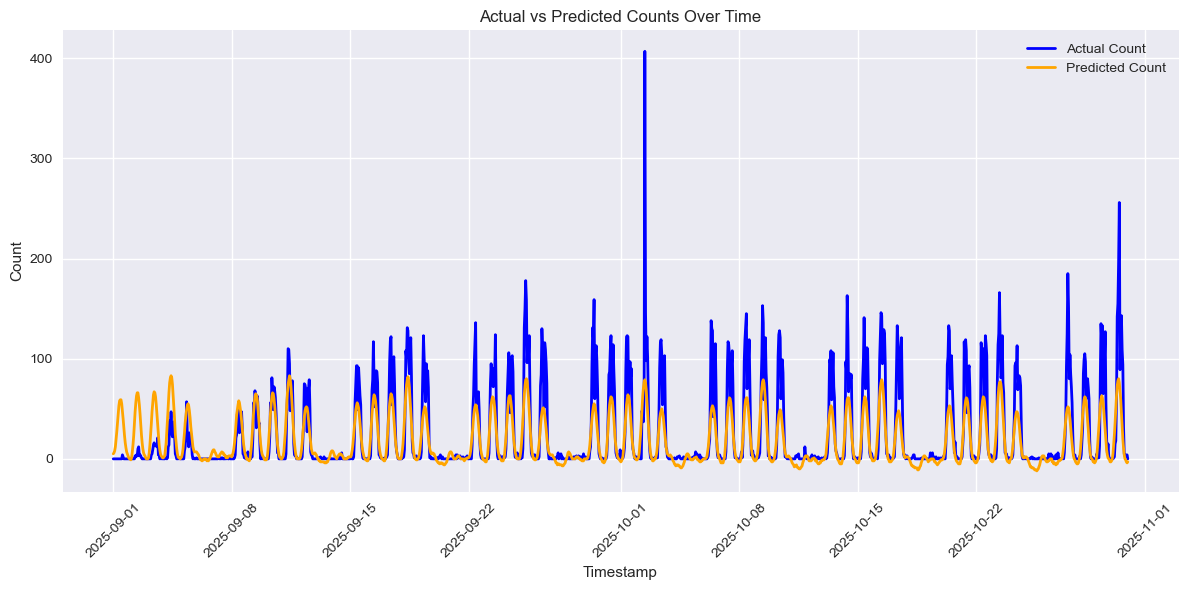

In [73]:
import pandas as pd
import matplotlib.pyplot as plt



# Plotting
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 6))
plt.plot(df_merged['timestamp'], df_merged['actual_count'], label='Actual Count', color='blue', linewidth=2)
plt.plot(df_merged['timestamp'], df_merged['predicted_count'], label='Predicted Count', color='orange', linewidth=2)

plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.title('Actual vs Predicted Counts Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# final testing of LSTM Model

In [1]:
import pandas as pd

df = pd.read_excel(r"C:\Users\ISMAIMZ\OneDrive - Hapag-Lloyd AG\Documents\DA\Booking time prediction\South_europe\RSE_copy.xlsx")

df.set_index('Initial_SI_received_time', inplace=True)
df['day_of_week'] = df.index.dayofweek
df['hour'] = df.index.hour
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

df['si_received_count'] = 1
hourly_si = df['si_received_count'].resample('h').sum()
hourly_si_filtered = hourly_si['2023-01-01':'2025-08-31']

calendar_features = df[['day_of_week', 'is_weekend']].copy()
calendar_features_hourly = calendar_features.resample('h').max().fillna(0)

hourly_si_filtered = hourly_si_filtered.to_frame(name='SI_count')
calendar_features_filtered = calendar_features_hourly.reindex(hourly_si_filtered.index, fill_value=0)
hourly_si_filtered = hourly_si_filtered.join(calendar_features_filtered)

hourly_si_filtered['day_of_week'] = hourly_si_filtered['day_of_week'].astype(int)
hourly_si_filtered['is_weekend'] = hourly_si_filtered['is_weekend'].astype(int)

In [18]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

features = ['SI_count', 'day_of_week', 'is_weekend']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(hourly_si_filtered[features])

seq_len = 720              
forecast_horizon = 1440    

X, y = [], []

for i in range(seq_len, len(scaled_data) - forecast_horizon):

    X.append(scaled_data[i-seq_len:i])
    y.append(scaled_data[i:i+forecast_horizon, 0])

X = np.array(X)
y = np.array(y)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Dense(forecast_horizon)   
])

model.compile(optimizer="adam", loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, lr_schedule],
    verbose=1
)

Epoch 1/150
266/266 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - loss: 0.0053 - val_loss: 0.0172 - learning_rate: 0.0010
Epoch 2/150
266/266 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - loss: 0.0030 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 3/150
266/266 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - loss: 0.0026 - val_loss: 0.0141 - learning_rate: 0.0010
Epoch 4/150
266/266 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - loss: 0.0024 - val_loss: 0.0137 - learning_rate: 0.0010
Epoch 5/150
266/266 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - loss: 0.0024 - val_loss: 0.0131 - learning_rate: 0.0010
Epoch 6/150
266/266 ━━━━━━━━━━━━━━━━━━━━ 341s 1s/step - loss: 0.0023 - val_loss: 0.0132 - learning_rate: 0.0010
Epoch 7/150
266/266 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - loss: 0.0022 - val_loss: 0.0113 - learning_rate: 0.0010
Epoch 8/150
266/266 ━━━━━━━━━━━━━━━━━━━━ 281s 1s/step - loss: 0.0022 - val_loss: 0.0115 - learning_rate: 0.0010
Epoch 9/150
266/266 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - loss: 0.0022 - val_loss: 0.0117 - learning_rate:

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

133/133 ━━━━━━━━━━━━━━━━━━━━ 23s 175ms/step
MAE: 0.05533833333049682
RMSE: 0.10015487660624689
R²: 0.6748494217391972


In [28]:
model.save("LSTM_model.h5")

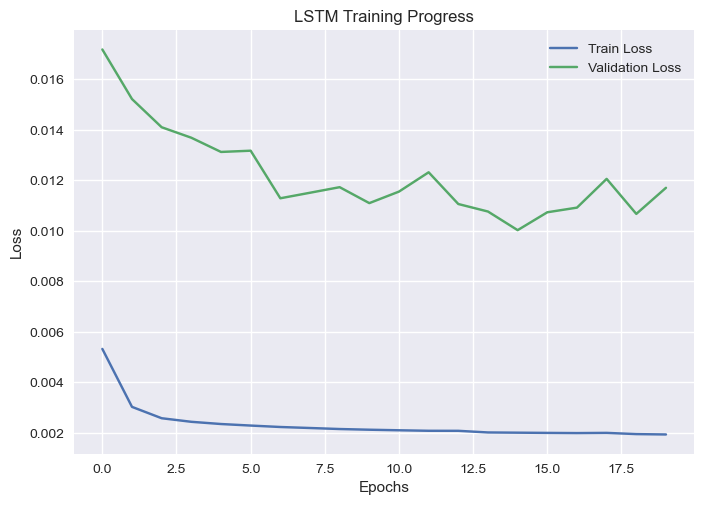

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training Progress')
plt.show()

In [22]:
import pandas as pd
from datetime import timedelta

# Take last sequence from dataset
last_sequence = scaled_data[-seq_len:]
last_sequence = last_sequence.reshape(1, seq_len, scaled_data.shape[1])

# Predict 1440 hours directly
future_pred = model.predict(last_sequence, verbose=0)[0]   # shape (1440,)

# Reshape for inverse scaling
future_pred_full = future_pred.reshape(-1, 1)

# Pad with zeros for other features if >1 input feature
future_pred_padded = np.concatenate([
    future_pred_full,
    np.zeros((forecast_horizon, scaled_data.shape[1] - 1))
], axis=1)

# Inverse transform back to original scale
future_pred_inv = scaler.inverse_transform(future_pred_padded)[:, 0]

# Build timestamps
last_timestamp = hourly_si_filtered.index[-1]
future_timestamps = [last_timestamp + timedelta(hours=i+1) for i in range(forecast_horizon)]

# Forecast DataFrame
df_forecast_lstm_multi_out = pd.DataFrame({
    'timestamp': future_timestamps,
    'predicted_si_count': future_pred_inv
})

print(df_forecast_lstm_multi_out)   # preview first 48 hours

               timestamp  predicted_si_count
0    2025-09-01 00:00:00           -6.023904
1    2025-09-01 01:00:00           -4.657006
2    2025-09-01 02:00:00           -5.221730
3    2025-09-01 03:00:00           -1.306213
4    2025-09-01 04:00:00            4.146693
...                  ...                 ...
1435 2025-10-30 19:00:00           -4.634521
1436 2025-10-30 20:00:00           -3.338405
1437 2025-10-30 21:00:00           -2.459132
1438 2025-10-30 22:00:00           -4.340684
1439 2025-10-30 23:00:00           -5.358839

[1440 rows x 2 columns]


In [23]:
df_forecast_lstm_multi_out.to_csv('test.csv')

In [24]:
import pandas as pd

df = pd.read_excel("sep_oct_final.xlsx")

df = df.rename(columns={'hour': 'timestamp',
                        'count': 'actual_count'})

In [25]:
df_1 = pd.read_csv(r"C:\Users\ISMAIMZ\OneDrive - Hapag-Lloyd AG\Documents\DA\Booking time prediction\South_europe\test.csv")

df_1 = df_1.rename(columns={'predicted_si_count': 'predicted_count'})
df_1['predicted_count'] = df_1['predicted_count'].astype(int) 
df_1['timestamp'] = pd.to_datetime(df_1['timestamp'])

In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df_merged = pd.merge(df, df_1, on='timestamp', how='inner')

def classify_prediction(row):
    actual = row['actual_count']
    predicted = row['predicted_count']

    if actual == predicted:
        return 'Exact Match'
    elif actual == 0:
        return 'No SI Received'
    elif abs(actual - predicted) <= 3:
        return '+/- 3 range'
    elif abs(actual - predicted) <= 5:
        return '+/- 5 range'
    elif abs(actual - predicted) <= 10:
        return '+/- 10 Range'
    else:
        return 'More than +/- 10 Range'


df_merged['match_status'] = df_merged.apply(classify_prediction, axis=1)

actuals = df_merged['actual_count']
preds = df_merged['predicted_count']

mae = mean_absolute_error(actuals, preds)
rmse = np.sqrt(mean_squared_error(actuals, preds))
mape = np.mean(np.abs((actuals - preds) / np.where(actuals==0, 1, actuals))) * 100
r2 = r2_score(actuals, preds)

print("Error Metrics:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.3f}")

print("\nBucket Distribution:")
print(df_merged['match_status'].value_counts())


print("\nSample Classified Data:")
print(df_merged[['timestamp', 'actual_count', 'predicted_count', 'match_status']])

Error Metrics:
MAE  : 14.53
RMSE : 26.15
MAPE : 307.53%
R²   : 0.617

Bucket Distribution:
match_status
No SI Received            498
More than +/- 10 Range    436
+/- 3 range               203
+/- 10 Range              124
Exact Match               105
+/- 5 range                74
Name: count, dtype: int64

Sample Classified Data:
               timestamp  actual_count  predicted_count    match_status
0    2025-09-01 00:00:00             0                6  No SI Received
1    2025-09-01 01:00:00             0                5  No SI Received
2    2025-09-01 02:00:00             0                5  No SI Received
3    2025-09-01 03:00:00             0                1  No SI Received
4    2025-09-01 04:00:00             0                4  No SI Received
...                  ...           ...              ...             ...
1435 2025-10-30 19:00:00             3                5     +/- 3 range
1436 2025-10-30 20:00:00             4                3     +/- 3 range
1437 2025-10-30 2

In [29]:
df_merged.to_excel('multioutput_forecasting_result.xlsx')

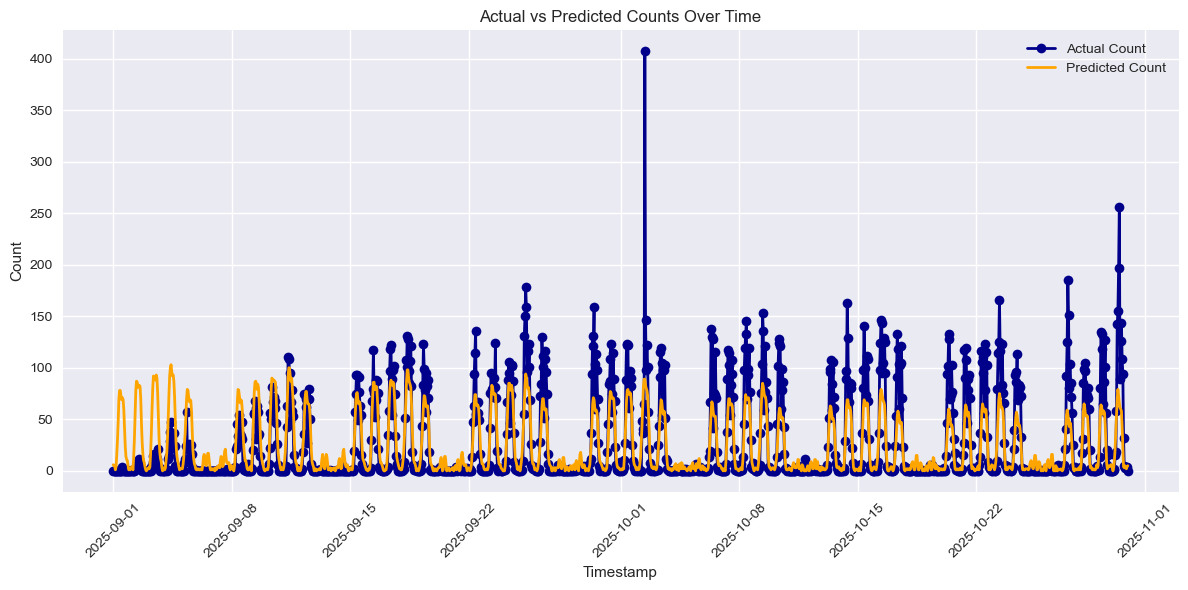

In [27]:
import pandas as pd
import matplotlib.pyplot as plt



# Plotting
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 6))
plt.plot(df_merged['timestamp'], df_merged['actual_count'], label='Actual Count', color='darkblue',marker='o', linewidth=2)
plt.plot(df_merged['timestamp'], df_merged['predicted_count'], label='Predicted Count', color='orange',marker='x', linewidth=2)

plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.title('Actual vs Predicted Counts Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

features = ['SI_count', 'day_of_week', 'is_weekend']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(hourly_si_filtered[features])

seq_len = 24
X, y = [], []

for i in range(seq_len, len(scaled_data)):
    X.append(scaled_data[i-seq_len:i])
    y.append(scaled_data[i,0])

X = np.array(X)
y = np.array(y)

split_ratio = 0.8

split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model = Sequential([
            Input(shape=(X_train.shape[1], X_train.shape[2])),
            LSTM(64),
            Dropout(0.2),
            Dense(1)
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

history = model.fit(
    X_train, y_train,
    epochs = 300,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop,lr_schedule],
    verbose=1
)


Epoch 1/300
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 0.0050 - val_loss: 0.0125 - learning_rate: 1.0000e-04
Epoch 2/300
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.0025 - val_loss: 0.0080 - learning_rate: 1.0000e-04
Epoch 3/300
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.0022 - val_loss: 0.0071 - learning_rate: 1.0000e-04
Epoch 4/300
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0020 - val_loss: 0.0068 - learning_rate: 1.0000e-04
Epoch 5/300
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0019 - val_loss: 0.0064 - learning_rate: 1.0000e-04
Epoch 6/300
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0018 - val_loss: 0.0064 - learning_rate: 1.0000e-04
Epoch 7/300
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0018 - val_loss: 0.0061 - learning_rate: 1.0000e-04
Epoch 8/300
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0017 - val_loss: 0.0059 - learning_rate: 1.0000e-04
Epoch 9/300
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 13s 1

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
MAE: 0.03292733684520035
RMSE: 0.06061735301610933
R²: 0.8829920093987071


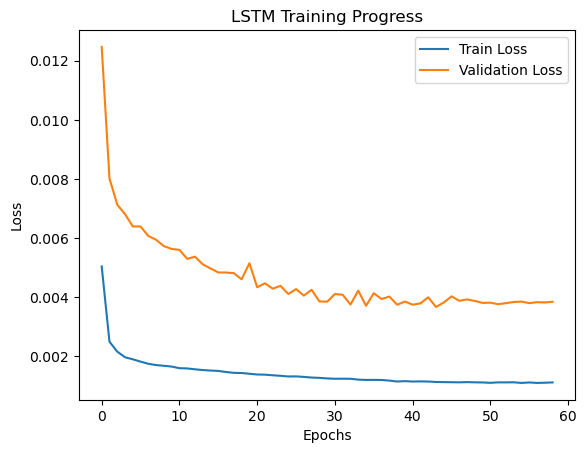

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training Progress')
plt.show()

In [22]:
model.save("LSTM_final_model.h5")

In [23]:
import numpy as np
import pandas as pd
from datetime import timedelta

seq_len = 24
forecast_horizon = 1440


last_sequence = scaled_data[-seq_len:]
last_sequence = last_sequence.reshape(1, seq_len, scaled_data.shape[1])

future_pred = []
current_input = last_sequence.copy()

for _ in range(forecast_horizon):
    next_pred = model.predict(current_input)
    future_pred.append(next_pred[0, 0])

    next_pred_reshaped = next_pred.reshape(1, 1, 1)

    if scaled_data.shape[1] > 1:
        pad = np.zeros((1, 1, scaled_data.shape[1] - 1))
        next_step = np.concatenate((next_pred_reshaped, pad), axis=2)
    else:
        next_step = next_pred_reshaped

    current_input = np.concatenate((current_input[:, 1:, :], next_step), axis=1)

future_pred_full = np.array(future_pred).reshape(-1, 1)

future_pred_padded = np.concatenate([
    future_pred_full,           
    np.zeros((forecast_horizon, scaled_data.shape[1] - 1))], axis=1)

future_pred_inv = scaler.inverse_transform(future_pred_padded)[:, 0]

total_si_next_48 = future_pred_inv.sum()
print(f"Predicted total SI count for next 48 hours: {total_si_next_48:.2f}")

last_timestamp = hourly_si_filtered.index[-1]
future_timestamps = [last_timestamp + timedelta(hours=i+1) for i in range(forecast_horizon)]

df_forecast_lstm = pd.DataFrame({
    'timestamp': future_timestamps,
    'predicted_si_count': future_pred_inv
})

print(df_forecast_lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━

In [24]:
df_forecast_lstm.to_csv('test.csv')

In [25]:
import pandas as pd

df = pd.read_excel(r"C:\Users\ISMAIMZ\OneDrive - Hapag-Lloyd AG\Documents\DA\Booking time prediction\South_europe\sep_oct_final.xlsx")

df = df.rename(columns={'hour': 'timestamp',
                        'count': 'actual_count'})

In [26]:
df_1 = pd.read_csv(r"C:\Users\ISMAIMZ\OneDrive - Hapag-Lloyd AG\Documents\DA\Booking time prediction\South_europe\test.csv")

df_1 = df_1.rename(columns={'predicted_si_count': 'predicted_count'})
df_1['predicted_count'] = df_1['predicted_count'].astype(int) 
df_1['timestamp'] = pd.to_datetime(df_1['timestamp'])

In [27]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df_merged = pd.merge(df, df_1, on='timestamp', how='inner')

def classify_prediction(row):
    actual = row['actual_count']
    predicted = row['predicted_count']

    if actual == predicted:
        return 'Exact Match'
    elif actual == 0:
        return 'No SI Received'
    elif abs(actual - predicted) <= 3:
        return '+/- 3 range'
    elif abs(actual - predicted) <= 5:
        return '+/- 5 range'
    elif abs(actual - predicted) <= 10:
        return '+/- 10 Range'
    else:
        return 'More than +/- 10 Range'


df_merged['match_status'] = df_merged.apply(classify_prediction, axis=1)

actuals = df_merged['actual_count']
preds = df_merged['predicted_count']

mae = mean_absolute_error(actuals, preds)
rmse = np.sqrt(mean_squared_error(actuals, preds))
mape = np.mean(np.abs((actuals - preds) / np.where(actuals==0, 1, actuals))) * 100
r2 = r2_score(actuals, preds)

print("Error Metrics:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.3f}")

print("\nBucket Distribution:")
print(df_merged['match_status'].value_counts())


print("\nSample Classified Data:")
print(df_merged[['timestamp', 'actual_count', 'predicted_count', 'match_status']])

Error Metrics:
MAE  : 43.50
RMSE : 58.23
MAPE : 1725.87%
R²   : -0.902

Bucket Distribution:
match_status
More than +/- 10 Range    681
No SI Received            540
+/- 10 Range               80
+/- 5 range                63
+/- 3 range                57
Exact Match                19
Name: count, dtype: int64

Sample Classified Data:
               timestamp  actual_count  predicted_count    match_status
0    2025-09-01 00:00:00             0                1  No SI Received
1    2025-09-01 01:00:00             0                0     Exact Match
2    2025-09-01 02:00:00             0                0     Exact Match
3    2025-09-01 03:00:00             0                2  No SI Received
4    2025-09-01 04:00:00             0                5  No SI Received
...                  ...           ...              ...             ...
1435 2025-10-30 19:00:00             3               -4    +/- 10 Range
1436 2025-10-30 20:00:00             4               -2    +/- 10 Range
1437 2025-10-30

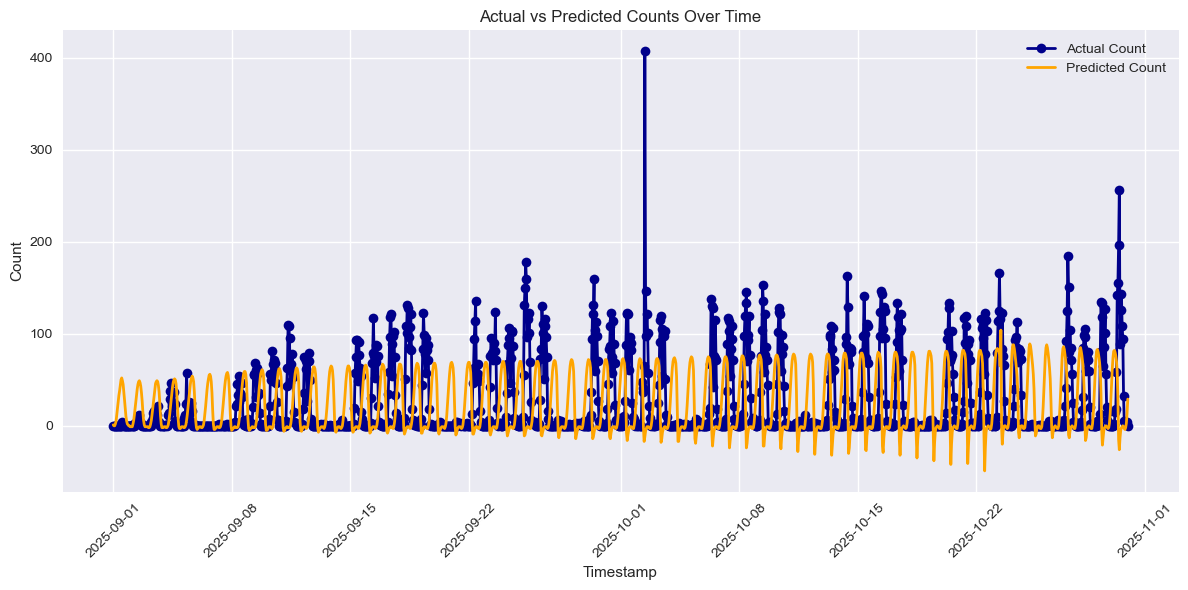

In [28]:
import pandas as pd
import matplotlib.pyplot as plt



# Plotting
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 6))
plt.plot(df_merged['timestamp'], df_merged['actual_count'], label='Actual Count', color='darkblue',marker='o', linewidth=2)
plt.plot(df_merged['timestamp'], df_merged['predicted_count'], label='Predicted Count', color='orange',marker='x', linewidth=2)

plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.title('Actual vs Predicted Counts Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

features = ['SI_count', 'day_of_week', 'is_weekend']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(hourly_si_filtered[features])

seq_len = 720              
forecast_horizon = 1440    

X, y = [], []

for i in range(seq_len, len(scaled_data) - forecast_horizon):

    X.append(scaled_data[i-seq_len:i])
    y.append(scaled_data[i:i+forecast_horizon, 0])

X = np.array(X)
y = np.array(y)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Conv1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu'),
    Dropout(0.2),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(forecast_horizon)   
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, lr_schedule],
    verbose=1
)

Epoch 1/150
266/266 ━━━━━━━━━━━━━━━━━━━━ 266s 991ms/step - loss: 0.0093 - val_loss: 0.0295 - learning_rate: 1.0000e-04
Epoch 2/150
266/266 ━━━━━━━━━━━━━━━━━━━━ 279s 1s/step - loss: 0.0054 - val_loss: 0.0196 - learning_rate: 1.0000e-04
Epoch 3/150
266/266 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - loss: 0.0045 - val_loss: 0.0191 - learning_rate: 1.0000e-04
Epoch 4/150
266/266 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - loss: 0.0043 - val_loss: 0.0183 - learning_rate: 1.0000e-04
Epoch 5/150
266/266 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - loss: 0.0041 - val_loss: 0.0178 - learning_rate: 1.0000e-04
Epoch 6/150
266/266 ━━━━━━━━━━━━━━━━━━━━ 279s 1s/step - loss: 0.0038 - val_loss: 0.0171 - learning_rate: 1.0000e-04
Epoch 7/150
266/266 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - loss: 0.0036 - val_loss: 0.0159 - learning_rate: 1.0000e-04
Epoch 8/150
266/266 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - loss: 0.0034 - val_loss: 0.0157 - learning_rate: 1.0000e-04
Epoch 9/150
266/266 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - loss: 0.0032 

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

133/133 ━━━━━━━━━━━━━━━━━━━━ 26s 192ms/step
MAE: 0.0702020340776397
RMSE: 0.11946115104813496
R²: 0.5318461951858868


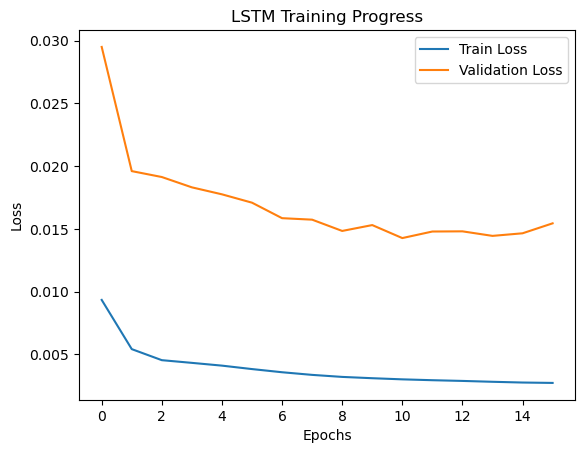

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training Progress')
plt.show()

In [7]:
import pandas as pd
from datetime import timedelta

# Take last sequence from dataset
last_sequence = scaled_data[-seq_len:]
last_sequence = last_sequence.reshape(1, seq_len, scaled_data.shape[1])

# Predict 1440 hours directly
future_pred = model.predict(last_sequence, verbose=0)[0]   # shape (1440,)

# Reshape for inverse scaling
future_pred_full = future_pred.reshape(-1, 1)

# Pad with zeros for other features if >1 input feature
future_pred_padded = np.concatenate([
    future_pred_full,
    np.zeros((forecast_horizon, scaled_data.shape[1] - 1))
], axis=1)

# Inverse transform back to original scale
future_pred_inv = scaler.inverse_transform(future_pred_padded)[:, 0]

# Build timestamps
last_timestamp = hourly_si_filtered.index[-1]
future_timestamps = [last_timestamp + timedelta(hours=i+1) for i in range(forecast_horizon)]

# Forecast DataFrame
df_forecast_lstm_multi_out = pd.DataFrame({
    'timestamp': future_timestamps,
    'predicted_si_count': future_pred_inv
})

print(df_forecast_lstm_multi_out)   # preview first 48 hours

               timestamp  predicted_si_count
0    2025-09-01 00:00:00           -3.054557
1    2025-09-01 01:00:00           -1.252321
2    2025-09-01 02:00:00            0.653975
3    2025-09-01 03:00:00            5.304621
4    2025-09-01 04:00:00           10.585532
...                  ...                 ...
1435 2025-10-30 19:00:00            6.705221
1436 2025-10-30 20:00:00            2.221821
1437 2025-10-30 21:00:00           -1.053085
1438 2025-10-30 22:00:00           -1.562024
1439 2025-10-30 23:00:00           -2.131358

[1440 rows x 2 columns]


In [8]:
df_forecast_lstm_multi_out.to_csv('test.csv')

In [13]:
import pandas as pd

df = pd.read_excel(r"C:\Users\ISMAIMZ\OneDrive - Hapag-Lloyd AG\Documents\DA\Booking time prediction\South_europe\sep_oct_final.xlsx")

df = df.rename(columns={'hour': 'timestamp',
                        'count': 'actual_count'})

In [14]:
df_1 = pd.read_csv(r"C:\Users\ISMAIMZ\OneDrive - Hapag-Lloyd AG\Documents\DA\Booking time prediction\South_europe\test.csv")

df_1 = df_1.rename(columns={'predicted_si_count': 'predicted_count'})
df_1['predicted_count'] = df_1['predicted_count'].astype(int) 
df_1['timestamp'] = pd.to_datetime(df_1['timestamp'])

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df_merged = pd.merge(df, df_1, on='timestamp', how='inner')

def classify_prediction(row):
    actual = row['actual_count']
    predicted = row['predicted_count']

    if actual == predicted:
        return 'Exact Match'
    elif actual == 0:
        return 'No SI Received'
    elif abs(actual - predicted) <= 3:
        return '+/- 3 range'
    elif abs(actual - predicted) <= 5:
        return '+/- 5 range'
    elif abs(actual - predicted) <= 10:
        return '+/- 10 Range'
    else:
        return 'More than +/- 10 Range'


df_merged['match_status'] = df_merged.apply(classify_prediction, axis=1)

actuals = df_merged['actual_count']
preds = df_merged['predicted_count']

mae = mean_absolute_error(actuals, preds)
rmse = np.sqrt(mean_squared_error(actuals, preds))
mape = np.mean(np.abs((actuals - preds) / np.where(actuals==0, 1, actuals))) * 100
r2 = r2_score(actuals, preds)

print("Error Metrics:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.3f}")

print("\nBucket Distribution:")
print(df_merged['match_status'].value_counts())


print("\nSample Classified Data:")
print(df_merged[['timestamp', 'actual_count', 'predicted_count', 'match_status']])

Error Metrics:
MAE  : 17.10
RMSE : 29.80
MAPE : 355.41%
R²   : 0.502

Bucket Distribution:
match_status
No SI Received            510
More than +/- 10 Range    463
+/- 3 range               166
+/- 10 Range              147
+/- 5 range                78
Exact Match                76
Name: count, dtype: int64

Sample Classified Data:
               timestamp  actual_count  predicted_count    match_status
0    2025-09-01 00:00:00             0                3  No SI Received
1    2025-09-01 01:00:00             0                1  No SI Received
2    2025-09-01 02:00:00             0                1  No SI Received
3    2025-09-01 03:00:00             0                5  No SI Received
4    2025-09-01 04:00:00             0               11  No SI Received
...                  ...           ...              ...             ...
1435 2025-10-30 19:00:00             3                7     +/- 5 range
1436 2025-10-30 20:00:00             4                2     +/- 3 range
1437 2025-10-30 2

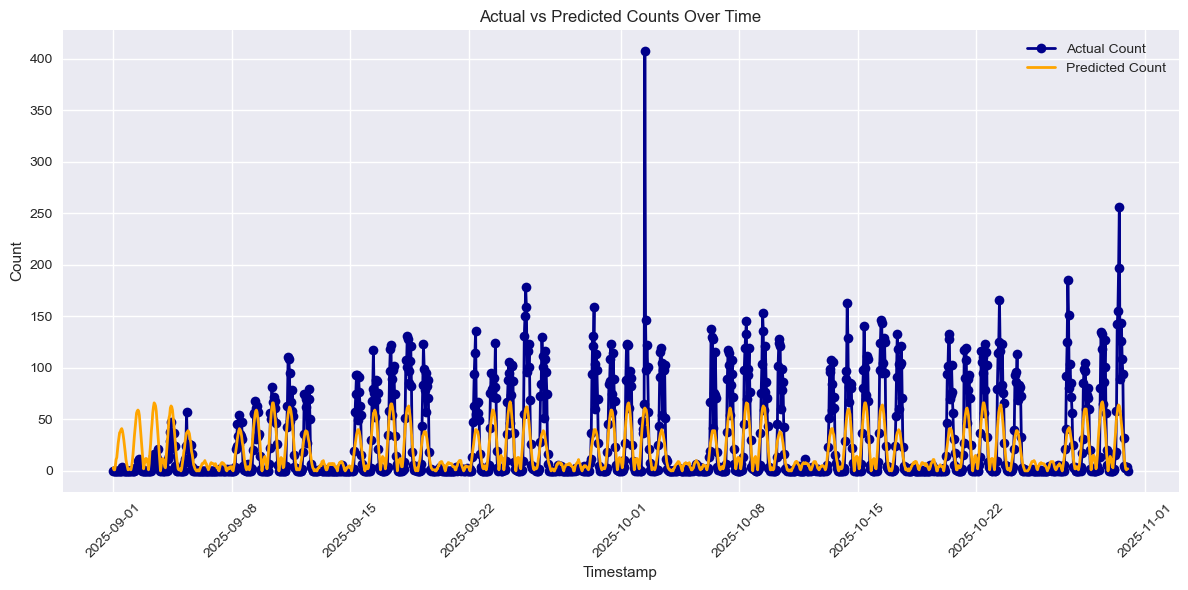

In [16]:
import pandas as pd
import matplotlib.pyplot as plt



# Plotting
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 6))
plt.plot(df_merged['timestamp'], df_merged['actual_count'], label='Actual Count', color='darkblue',marker='o', linewidth=2)
plt.plot(df_merged['timestamp'], df_merged['predicted_count'], label='Predicted Count', color='orange',marker='x', linewidth=2)

plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.title('Actual vs Predicted Counts Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
model.save("Conv1D_model.h5")